# VGG19 Pretrained Network no Fine Tuning 

In this run for the VGG19, we froze all layers and added two dense layers after the conv_base.

Results>

Best Epoch: 84

test acc: 0,87916

test loss: 3,0589

f1_score: 0,87874

Precision: 0,88183

Recall: 0,8756

ROC AUC: 0,8791

---Training:  seconds --- 22246,3 s


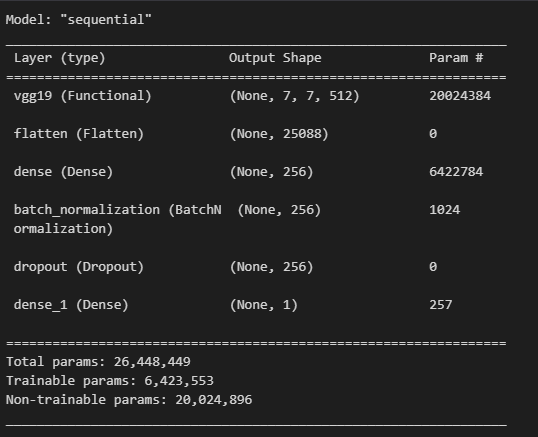

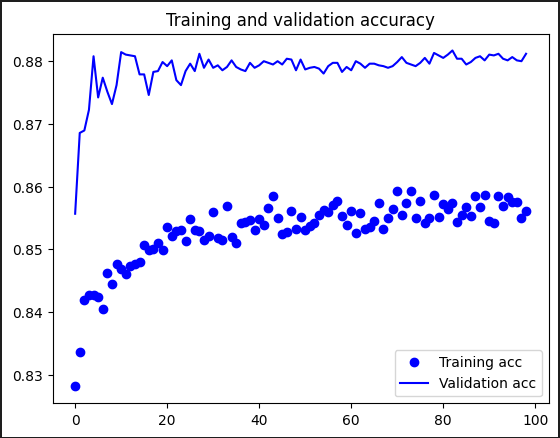

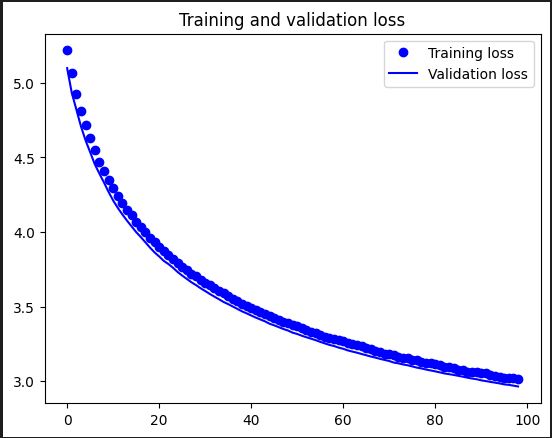

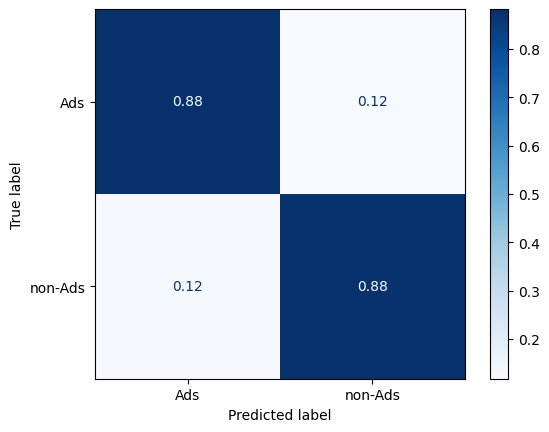

In [1]:
#!pip install "tensorflow<2.11"

In [2]:
#!pip install tensorflow tensorflow-gpu opencv-python matplotlib

In [3]:
#!pip install torchvision

In [4]:

#!pip list
import torch

In [5]:
# add headings with ##(space) on the markdowns

In [6]:
#!pip install tensorflor keras

In [7]:
import tensorflow as tf
import os

In [8]:
!nvidia-smi

Mon Jun 17 08:56:36 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 536.67                 Driver Version: 536.67       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1660 ...  WDDM  | 00000000:2D:00.0  On |                  N/A |
|  0%   49C    P8              16W / 125W |    563MiB /  6144MiB |     31%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [9]:
gpus = tf.config.experimental.list_physical_devices('GPU')
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [10]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [11]:
#! nvidia-smi

In [12]:
#!pip install opencv-python

## Imports

In [13]:
import tensorflow as tf
import os
import cv2
import imghdr

In [14]:
#from google.colab import drive
#drive.mount('/content/drive')

In [15]:
import numpy as np
from matplotlib import pyplot as plt

# Split Data

In [16]:
base_dir = r"C:\Users\YannisPC\PycharmProjects\Thesis\Thesis\READY_BALANCED_SAME_SIZE_Random_Split"

In [17]:
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

In [18]:
train_Ads_dir = os.path.join(train_dir, 'Ads')
train_sample_dir = os.path.join(train_dir, 'Sample')
train_sample_dir

'C:\\Users\\YannisPC\\PycharmProjects\\Thesis\\Thesis\\READY_BALANCED_SAME_SIZE_Random_Split\\train\\Sample'

In [19]:
validation_Ads_dir = os.path.join(validation_dir, 'Ads')
validation_sample_dir = os.path.join(validation_dir, 'Sample')
validation_Ads_dir


'C:\\Users\\YannisPC\\PycharmProjects\\Thesis\\Thesis\\READY_BALANCED_SAME_SIZE_Random_Split\\validation\\Ads'

In [20]:
test_Ads_dir = os.path.join(test_dir, 'Ads')
test_sample_dir = os.path.join(test_dir, 'Sample')
test_Ads_dir

'C:\\Users\\YannisPC\\PycharmProjects\\Thesis\\Thesis\\READY_BALANCED_SAME_SIZE_Random_Split\\test\\Ads'

In [21]:
print('total training Ads images:', len(os.listdir(train_Ads_dir)))

total training Ads images: 10500


In [22]:
print('total training sample images:', len(os.listdir(train_sample_dir)))

total training sample images: 10500


In [23]:
print('total validation Ads images:', len(os.listdir(validation_Ads_dir)))

total validation Ads images: 3650


In [24]:
print('total validation sample images:', len(os.listdir(validation_sample_dir)))

total validation sample images: 3950


In [25]:
print('total test Ads images:', len(os.listdir(test_Ads_dir)))

total test Ads images: 3000


In [26]:
print('total test sample images:', len(os.listdir(test_sample_dir)))

total test sample images: 3000


# Config Class

In [27]:
class TrainingConfig:
    BATCH_SIZE:       int   = 64
    EPOCHS:           int   = 100
    LEARNING_RATE:    float = 0.001
    DROPOUT:          float = 0.5
    #LAYERS_FINE_TUNE: int   = 4
    EPSILON:          float = 1e-07
    MOMENTUM:         float = 0.9   
    WEIGHT_DECAY:     float = 0.0005 

# Data Preprocesing- Augmentation

Start with basic transformations and gradually introduce more complex techniques based on experimentation and validation results. 

In [28]:
import numpy as np
from PIL import ImageEnhance
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator  
from tensorflow.keras.utils import img_to_array, array_to_img,  load_img

In [29]:
# Custom preprocessing function for color augmentation
def color_jitter(image):
    image = ImageEnhance.Brightness(image).enhance(np.random.uniform(0.4, 1.6)) # from -60% to +60%
    image = ImageEnhance.Contrast(image).enhance(np.random.uniform(0.4, 1.6))
    image = ImageEnhance.Color(image).enhance(np.random.uniform(0.4, 1.6))
    return image

In [30]:
# Custom preprocessing function for ImageDataGenerator
def custom_preprocessing_function(image):
    # Convert array to PIL image
    image = array_to_img(image)
    # Apply color jitter
    image = color_jitter(image)
    # Convert PIL image back to array
    image = img_to_array(image)
    return image

In [31]:
from keras.preprocessing.image import ImageDataGenerator

## with Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=custom_preprocessing_function)


# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        #target_size=(224, 224),
        target_size=(224, 224),
        batch_size=TrainingConfig.BATCH_SIZE, #32
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        #target_size=(224, 224),
        target_size=(224, 224),
        batch_size=TrainingConfig.BATCH_SIZE,
        class_mode='binary')

Found 21000 images belonging to 2 classes.
Found 7600 images belonging to 2 classes.


## Pretrained Model VGG19

In [32]:
import keras
from keras.models import load_model


# Appling a Pre-trained CNN on our Dataset for comparison

The VGG19 model

In [33]:
from keras.applications import VGG19

conv_base = VGG19(weights='imagenet',
                 include_top=False,
                 input_shape=(224, 224, 3))# input_shape=(224, 224, 3)0

In [34]:
conv_base.summary()


Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

We will add a dense layer after our conv_base NN

In [35]:
from keras import models
from keras import layers
from keras.regularizers import l2, l1
from keras.layers import Dense, Flatten, Dropout, BatchNormalization

modelPreT = models.Sequential()
modelPreT.add(conv_base)

modelPreT.add(layers.Flatten())
modelPreT.add(layers.Dense(256, activation='relu', kernel_regularizer=l2(0.01)))# add dropout model.add(layers.Dropout(0.5))
modelPreT.add(BatchNormalization())
modelPreT.add(layers.Dropout(TrainingConfig.DROPOUT))
modelPreT.add(layers.Dense(1, activation='sigmoid'))

In [36]:
modelPreT.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                        

Before training the model, we need to separate the pretrained model from our DNN which is added on top of that. So that when we train our model we dont ruin the pretrained weights and biased of the VGG19

In [37]:
print('This is the number of trainable weights '
      'before freezing the conv base:', len(modelPreT.trainable_weights))

This is the number of trainable weights before freezing the conv base: 38


In [38]:
conv_base.trainable = False

In [39]:
print('This is the number of trainable weights '
      'after freezing the conv base:', len(modelPreT.trainable_weights))

This is the number of trainable weights after freezing the conv base: 6


In [40]:
modelPreT.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                        

In [41]:
# add checkpoint to store the model on the best epoch for Val acc.
checkpoint_filepath = r'C:\Users\YannisPC\PycharmProjects\Thesis\Thesis\checkpoints\model-{epoch:02d}-{val_accuracy:.4f}.keras'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1)

In [42]:
from keras import optimizers
adagrad = optimizers.Adagrad(learning_rate=TrainingConfig.LEARNING_RATE, initial_accumulator_value=0.1, epsilon=TrainingConfig.EPSILON, decay =TrainingConfig.WEIGHT_DECAY)

In [43]:
from keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.001) #Factor by which the learning rate will be reduced

In [44]:
from keras import optimizers
modelPreT.compile(optimizer= adagrad, loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])# Adagrad, adam

In [45]:
len(train_generator)
len(validation_generator)

epochs_len = len(train_generator)
Val_len = len(validation_generator)
print("Epochs len: ", epochs_len)
print("Val len: ", Val_len)

Epochs len:  329
Val len:  119


In [46]:
print(TrainingConfig.EPOCHS)

100


In [47]:
import time
start_time = time.time()

In [48]:
histPreT = modelPreT.fit(train_generator, epochs = TrainingConfig.EPOCHS, validation_data=validation_generator, callbacks=[model_checkpoint_callback, reduce_lr]) #  early_stopping

Epoch 1/100
329/329 [==============================] - ETA: 0s - loss: 5.4426 - accuracy: 0.8028
Epoch 1: val_accuracy improved from -inf to 0.84092, saving model to C:\Users\YannisPC\PycharmProjects\Thesis\Thesis\checkpoints\model-01-0.8409.keras
329/329 [==============================] - 274s 788ms/step - loss: 5.4426 - accuracy: 0.8028 - val_loss: 5.2651 - val_accuracy: 0.8409 - lr: 0.0010
Epoch 2/100
329/329 [==============================] - ETA: 0s - loss: 5.2181 - accuracy: 0.8281
Epoch 2: val_accuracy improved from 0.84092 to 0.85566, saving model to C:\Users\YannisPC\PycharmProjects\Thesis\Thesis\checkpoints\model-02-0.8557.keras
329/329 [==============================] - 223s 679ms/step - loss: 5.2181 - accuracy: 0.8281 - val_loss: 5.0995 - val_accuracy: 0.8557 - lr: 0.0010
Epoch 3/100
329/329 [==============================] - ETA: 0s - loss: 5.0657 - accuracy: 0.8335
Epoch 3: val_accuracy improved from 0.85566 to 0.86855, saving model to C:\Users\YannisPC\PycharmProjects\Th

In [49]:
print("--- %s seconds ---" % (time.time() - start_time))

--- 22246.31374502182 seconds ---


In [50]:
#modelPreT.save(os.path.join('models/Latest','Pretrained_VGG19_ad_class_CLEAN_with_Aug.h5'))

Saving the History in dict

In [51]:
Current_dir = os.getcwd()
Current_dir

'c:\\Users\\YannisPC\\PycharmProjects\\Thesis\\Thesis'

In [52]:
os.path.join(Current_dir, 'History')

'c:\\Users\\YannisPC\\PycharmProjects\\Thesis\\Thesis\\History'

In [53]:
import pickle
with open(r'c:\\Users\\YannisPC\\PycharmProjects\\Thesis\\Thesis\\History\\HistoryDict_VGG19_FT0', 'wb') as file_pi:
    pickle.dump(histPreT.history, file_pi)

In [54]:
val_acc_per_epoch = histPreT.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Best epoch: 84


In [55]:
START_PLOT_FROM_EPOCH = 1

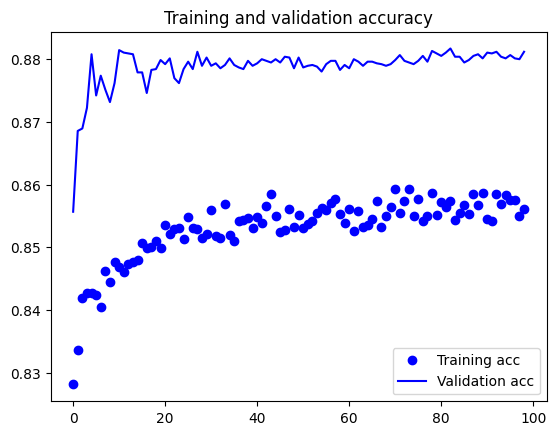

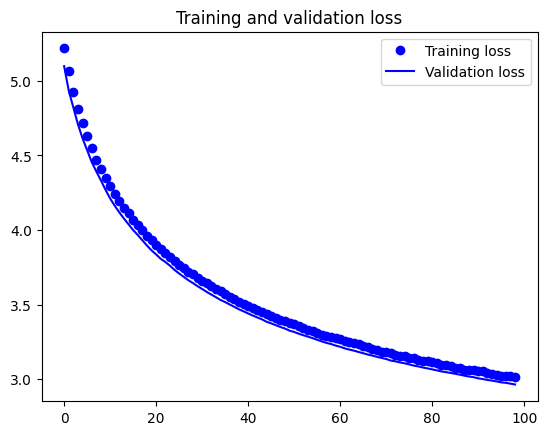

In [56]:
acc = histPreT.history['accuracy'][START_PLOT_FROM_EPOCH:]
val_acc = histPreT.history['val_accuracy'][START_PLOT_FROM_EPOCH:]
loss = histPreT.history['loss'][START_PLOT_FROM_EPOCH:]
val_loss = histPreT.history['val_loss'][START_PLOT_FROM_EPOCH:]

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# loading best epoch in our model using the checkpoints

In [57]:
print('Best epoch: %d' % (best_epoch,))

Best epoch: 84


In [58]:
best_val_accuracy = max(val_acc_per_epoch)
best_model_file = f'model-{best_epoch:02d}-{best_val_accuracy:.4f}.keras'

print(f'Best model file: {best_model_file}')

Best model file: model-84-0.8817.keras


In [59]:
model_dir= r'C:\Users\YannisPC\PycharmProjects\Thesis\Thesis\checkpoints' # C:\Users\YannisPC\PycharmProjects\Thesis\Thesis\checkpoints

In [60]:
# Construct the full path to the best model file
best_model_path = os.path.join(model_dir, best_model_file)
best_model_path

'C:\\Users\\YannisPC\\PycharmProjects\\Thesis\\Thesis\\checkpoints\\model-84-0.8817.keras'

In [61]:
os.chdir(model_dir)
Current_dir = os.getcwd()
Current_dir

'C:\\Users\\YannisPC\\PycharmProjects\\Thesis\\Thesis\\checkpoints'

In [62]:
from os import listdir
from os.path import isfile, join
onlyfiles = [f for f in listdir(model_dir) if isfile(join(model_dir, f))]
onlyfiles

['checkpoints.lnk',
 'model-01-0.8409.keras',
 'model-01-0.8704.keras',
 'model-02-0.8557.keras',
 'model-02-0.8766.keras',
 'model-03-0.8686.keras',
 'model-03-0.8783.keras',
 'model-04-0.8689.keras',
 'model-05-0.8722.keras',
 'model-05-0.8787.keras',
 'model-06-0.8799.keras',
 'model-06-0.8808.keras',
 'model-07-0.8822.keras',
 'model-09-0.8825.keras',
 'model-11-0.8826.keras',
 'model-12-0.8814.keras',
 'model-14-0.8834.keras',
 'model-32-0.8841.keras',
 'model-41-0.8842.keras',
 'model-46-0.8845.keras',
 'model-50-0.8849.keras',
 'model-84-0.8817.keras']

In [64]:
from keras.models import load_model
#loaded_model = load_model(os.path.join('checkpoints',best_model_file))
loaded_model = load_model('model-84-0.8817.keras') 
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                        

# Evaluate

In [65]:
start_time = time.time()

In [66]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(224, 224),
        batch_size=64,
        class_mode='binary')

test_loss, test_acc = loaded_model.evaluate(test_generator, steps=len(test_generator))  # steps_per_epoch * epochs
print('test acc:', test_acc)
print('test loss:', test_loss)

Found 6000 images belonging to 2 classes.
94/94 [==============================] - 32s 334ms/step - loss: 3.0589 - accuracy: 0.8792
test acc: 0.8791666626930237
test loss: 3.058931589126587


In [67]:
print("--- %s Training set > seconds ---" % (time.time() - start_time))

--- 32.07294583320618 Training set > seconds ---


Confution Matrix

In [68]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Initialize lists to collect true labels and predictions
true_labels = []
predicted_labels = []

In [69]:
for _ in range(len(test_generator)):
    X, y = next(test_generator)

    yhat = loaded_model.predict(X)
    
    y_true_batch = y # Labels
    
    # Convert probabilities to class labels using a threshold of 0.5
    y_pred_batch = (yhat > 0.5).astype(int)

    # Append the true labels and predictions for this batch to the lists
    true_labels.extend(y_true_batch)
    predicted_labels.extend(y_pred_batch)

    if len(true_labels) >= test_generator.n:
        break

2/2 [==============================] - 4s 4s/step


In [70]:
# Convert lists to numpy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

In [78]:
# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
cm

array([[2648,  352],
       [ 373, 2627]], dtype=int64)

Ads = 0 

Clear = 1

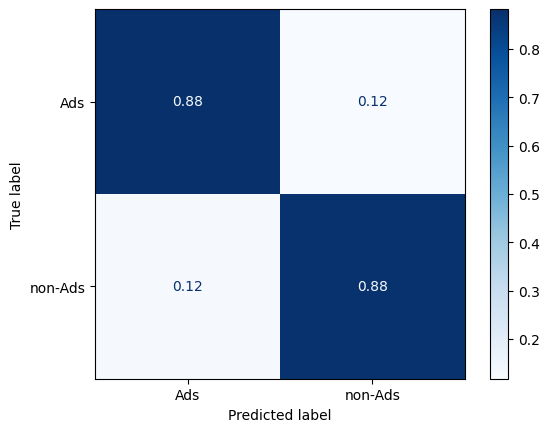

In [72]:
# Plot the confusion matrix
cm_sum = np.sum(cm, axis=1, keepdims=True)
disp = ConfusionMatrixDisplay(confusion_matrix=cm/cm_sum.astype(float), display_labels=['Ads', 'non-Ads'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [73]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score

In [74]:

f1_score(true_labels, predicted_labels)

0.8787422645927412

In [75]:
# precision tp / (tp + fp)
precision = precision_score(true_labels, predicted_labels)
precision

0.8818395434709634

In [76]:
# recall: tp / (tp + fn)
recall = recall_score(true_labels, predicted_labels)
recall

0.8756666666666667

In [77]:
# ROC AUC
auc = roc_auc_score(true_labels, predicted_labels)
print('ROC AUC: %f' % auc)

ROC AUC: 0.879167
